In [ ]:
from wcpdtoolbox.visualization import *
# from fastai.callback.hook import *
from fastai.test_utils import *
model = resnet18().cuda()

对于一个模型,我们可以轻易查看它的输入和输出.但是,它的中间层仍然对我不可知.

现在,我需要克服这个缺陷

## Summary Model

> 观察模型各层的grad

In [ ]:
c = L()

In [ ]:
adam = Adam(model.parameters(), 1e-4)

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_16.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


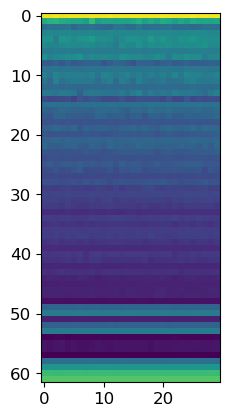

tensor(-74.4779, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
for i in range(30):
    l = L()
    x = model(torch.randn(20,3,64,64).cuda())
    x.sum().abs().backward()
    adam.step()
    for i in model.parameters():
        l.append(i)
    l = l.map(lambda x:to_detach(x.grad.abs().mean()))
    model.zero_grad()
    c.append(l)
c2 = c.copy()
c2.reverse()
plt.imshow(np.log1p(array(c2).T))
plt.show()

print(x.sum())

这样就可以看见它的梯度了,不过依然没有名字

### 制作一个显示梯度的callback

In [ ]:
learner = synth_learner()

In [ ]:
class GradShowCallback(Callback):
    def __init__(self, l, **kwargs): 
        assert not kwargs, f'Passed unknown events: {kwargs}'
        self.grad_list = l
    def before_step(self):
        k = L([to_detach(i.grad.abs().mean()) for i in self.learn.model.parameters()])
        self.grad_list.append(k)
    
    def after_fit(self):
        [plt.plot(i) for i in array(self.grad_list).T]
        plt.show()

In [ ]:
l = L()

epoch,train_loss,valid_loss,time
0,25.333673,27.027384,00:00
1,23.795195,21.430862,00:00
2,20.932470,15.259192,00:00
3,17.989950,11.353888,00:00
4,15.402375,8.668013,00:00
5,13.202624,6.830383,00:00
6,11.358438,5.623485,00:00
7,9.841968,4.950937,00:00
8,8.626709,4.664057,00:00
9,7.678516,4.614231,00:00


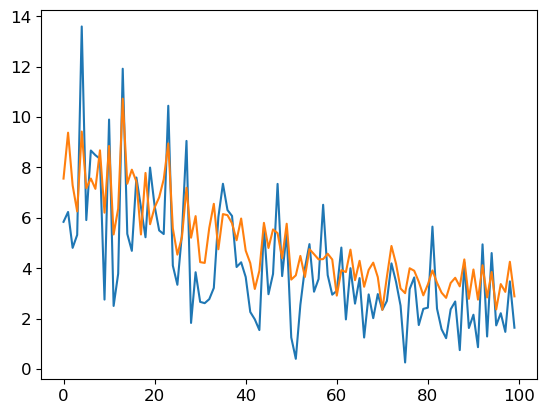

In [ ]:
learner.fit_one_cycle(10, cbs=GradShowCallback(l))

更新:

In [ ]:
from plotly import graph_objects as go

In [ ]:
class GradShowCallback(Callback):
    def __init__(self,l=None, show=True):
        self.grad_list = L() if l is None else l
        self.show = show
        
    def before_step(self):
        grads = []
        for i in self.learn.model.parameters():
            if not i.grad is None:
                grads.append(to_detach(i.grad.abs().mean()))
            else:
                grads.append(tensor(0.))
        self.grad_list.append(grads)
    
    def after_fit(self):
        if not self.show:
            return
        fig = go.Figure()
        name = [name for name, _ in self.learn.model.named_parameters()]
        arr = array(self.grad_list).T
        x = np.arange(len(self.grad_list))
        for a,n in zip(arr, name):
            fig.add_trace(go.Scatter(x=x, y=a, name=n))
        fig.show()

In [ ]:
learner = synth_learner()

epoch,train_loss,valid_loss,time
0,15.332655,15.399384,00:00
1,14.451164,12.325535,00:00
2,12.793344,8.908071,00:00
3,11.070920,6.616061,00:00
4,9.531049,5.079659,00:00
5,8.209394,4.044551,00:00
6,7.098516,3.371369,00:00
7,6.185102,2.984177,00:00
8,5.451753,2.818964,00:00
9,4.879062,2.789715,00:00


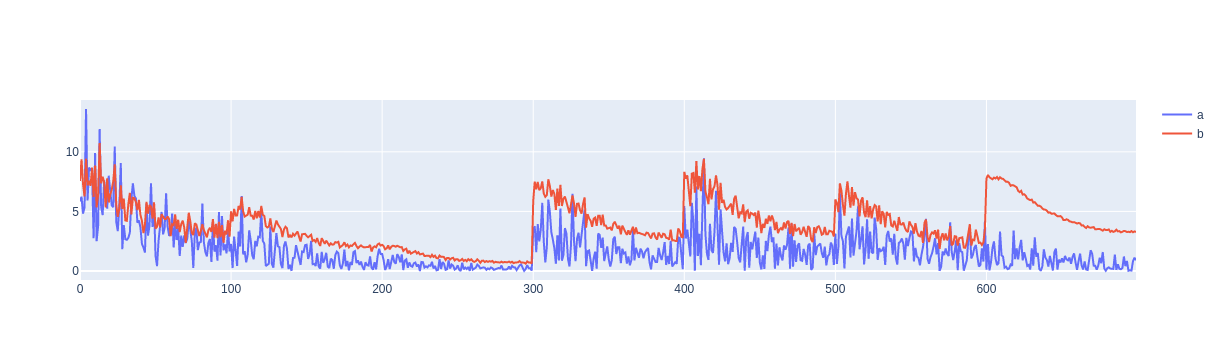

In [ ]:
learner.fit_one_cycle(10, cbs=GradShowCallback(l))